### How To: Evaluate model performance
Author: Jacob Schreiber

After training a model, the next step is almost always to evaluate model performance on a held-out test set. Likewise, when you have downloaded a model from somewhere else, the first step should be to evaluate the performance of the model on your data to make sure that it is performance in the ways that are most interesting and relevant to you. 

In this notebook, we will explore how to evaluate the performance of a model using the standard performance measures for Chrom/BPNet. I will emphasize that there is usually no single performance measure that is sufficient to evaluate performance or to compare two models and that measures which are basically slightly different equations on the same data (e.g., accuracy vs auROC or MSE vs MAE) are not that helpful. Rather, one should rely on a collection of performance measures that chop up the data in different ways, such as by focusing on differential predictions at important regions or splitting data into highly active and inactive regions.

In an earlier tutorial, we trained a BPNet model using the Python API to predict CTCF binding. Here, we will demonstrate how one would evaluate such a model without the training step, emulating the procedure for getting a model from somewhere else (e.g. the ENCODE portal) and confirming that it works well.

#### Loading up the evaluation data

Before even loading the model, you must load your data. Many BPNet performance measures focus on performance within peaks, so we will begin by loading up data there. For each example, we load the input sequence, the bigWigs containing the signal counts, and the bigWigs containing the control counts that are also inputs to these models. Make sure to filter out examples used in the training set chromosomes! Otherwise, you may get a distorted view of accuracy.

In [1]:
from tangermeme.io import extract_loci

peaks = "ctcf-bpnet/ENCFF199YFA.bed.gz"
seq = "/home/jmschrei/common/hg38.fa"
signals = ["ctcf-bpnet/ctcf-hepg2.+.bw", "ctcf-bpnet/ctcf-hepg2.-.bw"]
controls = ["ctcf-bpnet/ctcf-hepg2-control.+.bw", "ctcf-bpnet/ctcf-hepg2-control.-.bw"]

test_chroms = ['chr8', 'chr20'] # Remember to not include training set chroms!

X, y, X_ctl = extract_loci(peaks, seq, signals, in_signals=controls, chroms=test_chroms, verbose=True)
X.shape, X_ctl.shape, y.shape

Loading Loci: 100%|███████████████████████████████████████████████████████████████| 4780/4780 [00:00<00:00, 9409.00it/s]


(torch.Size([4780, 4, 2114]),
 torch.Size([4780, 2, 2114]),
 torch.Size([4780, 2, 1000]))

Now, we will load up our model and make predictions for those regions. If you are using a model that has been trained using the official TensorFlow repositories, please see the tutorial on how to load models from them. 

In [2]:
import torch
from tangermeme.predict import predict

model = torch.load("ctcf-bpnet/model.torch", weights_only=False)

y_logits, y_log_counts = predict(model, X, args=(X_ctl,), verbose=True)
y_logits.shape, y_log_counts.shape

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 327.23it/s]


(torch.Size([4780, 2, 1000]), torch.Size([4780, 1]))

We can start off by visualizing the predictions and the true data. Visualizations are always an important complement to the raw performance measures, because there are sometimes systematic issues that one cannot see from numbers alone but become immediately apparent in even a simple scatterplot.

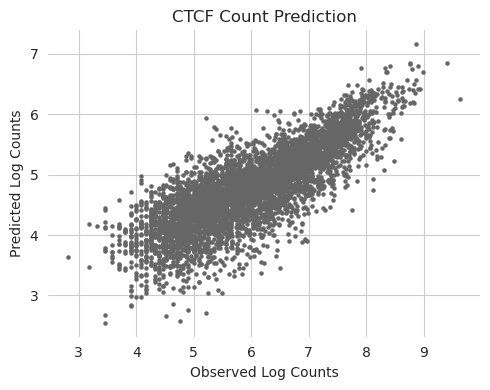

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

y_log = torch.log2(y[:, 0].sum(dim=-1) + 1)

plt.figure(figsize=(5, 4))
plt.scatter(y_log, y_log_counts[:, 0], c='0.4', s=5)
plt.title("CTCF Count Prediction")
plt.xlabel("Observed Log Counts")
plt.ylabel("Predicted Log Counts")

seaborn.despine(bottom=True, left=True)
plt.tight_layout()
plt.show()

We can also take a look at the profile predictions and compare them to the raw read counts for a region to make sure that the positioning of the predicted peaks as well as the offset between the positive and negative strand look right.

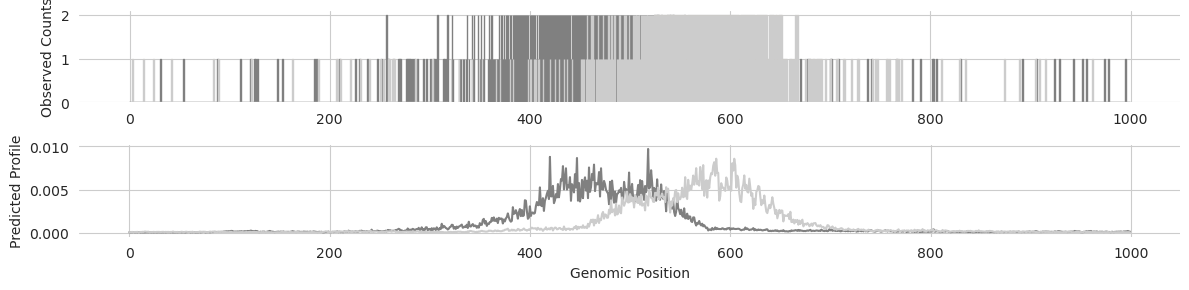

In [4]:
idx = 0

y_profile = torch.softmax(y_logits[idx], dim=-1)

plt.figure(figsize=(12, 3))
plt.subplot(211)
plt.bar(range(1000), y[idx, 0], edgecolor='0.5')
plt.bar(range(1000), y[idx, 1], edgecolor='0.8')
plt.ylabel("Observed Counts")
seaborn.despine(bottom=True, left=True)

plt.subplot(212)
plt.plot(y_profile[0], color='0.5')
plt.plot(y_profile[1], color='0.8')
plt.xlabel("Genomic Position")
plt.ylabel("Predicted Profile")
seaborn.despine(bottom=True, left=True)

plt.tight_layout()
plt.show()

#### Calculating all the performance measures

Now that we have the predictions across all peaks and the true readouts for those regions, and have verified that nothing seems to be systematically wrong with the predictions (such as not predicting peaks at all, predicting entirely NaNs or on a completely different scale, etc..), we can calculate the set of performance measures usually used for the BPNet models. This includes several measures of performance on the profile predictions, which are returned on a per-example basis, and several measures of performance on the log count predictions measured across the entire dataset.

To make it easy to calculate these measures, bpnet-lite has a built-in `calculate_performance_measures` method that takes in a set of predicted logit, log counts, and the true signal, and returns each of the measures as a dictionary.

In [5]:
from bpnetlite.performance import calculate_performance_measures

calculate_performance_measures(y_logits, y, y_log_counts)

{'profile_mnll': tensor([[581.3618, 550.1101],
         [473.1202, 466.9050],
         [593.5938, 614.1980],
         ...,
         [221.7323, 231.9723],
         [ 73.2827,  60.0348],
         [114.7720, 127.7667]]),
 'profile_jsd': tensor([[0.1123, 0.1003],
         [0.0901, 0.0802],
         [0.1060, 0.1074],
         ...,
         [0.3881, 0.4212],
         [0.5916, 0.6067],
         [0.6082, 0.6006]]),
 'profile_pearson': tensor([[0.8207, 0.8545],
         [0.8675, 0.8939],
         [0.8439, 0.8280],
         ...,
         [0.4721, 0.4487],
         [0.1961, 0.1671],
         [0.1180, 0.1142]]),
 'profile_spearman': tensor([[ 0.3892,  0.3287],
         [ 0.4911,  0.3688],
         [ 0.4207,  0.4164],
         ...,
         [ 0.5006,  0.3842],
         [ 0.0123, -0.3916],
         [ 0.0594, -0.3487]]),
 'count_pearson': tensor([0.8117]),
 'count_spearman': tensor([0.8103]),
 'count_mse': tensor([0.2029])}

There are several arguments that can be passed in to change the exact way that these measures are calculated. In the original BPNet paper, the *true* profiles are smoothed using a Gaussian filter with a sigma of 7 and a kernel width of 81. Those parameters can be passed in, and we can turn them on with the `smooth_true` argument.

In [6]:
calculate_performance_measures(y_logits, y, y_log_counts, smooth_true=True)

{'profile_mnll': tensor([[581.3618, 550.1101],
         [473.1202, 466.9050],
         [593.5938, 614.1980],
         ...,
         [221.7323, 231.9723],
         [ 73.2827,  60.0348],
         [114.7720, 127.7667]]),
 'profile_jsd': tensor([[0.0274, 0.0212],
         [0.0227, 0.0200],
         [0.0240, 0.0288],
         ...,
         [0.0719, 0.0806],
         [0.2072, 0.2333],
         [0.1962, 0.1585]]),
 'profile_pearson': tensor([[0.9106, 0.9406],
         [0.9468, 0.9632],
         [0.9403, 0.9258],
         ...,
         [0.8998, 0.8988],
         [0.6141, 0.6231],
         [0.4796, 0.5026]]),
 'profile_spearman': tensor([[0.8479, 0.8306],
         [0.8738, 0.7210],
         [0.8369, 0.8068],
         ...,
         [0.6850, 0.5676],
         [0.4384, 0.3346],
         [0.4329, 0.6163]]),
 'count_pearson': tensor([0.8117]),
 'count_spearman': tensor([0.8103]),
 'count_mse': tensor([0.2029])}

My personal opinion is that one should never smooth the true profile, but it is implemented in case you want to more closely match other repositories.

By default, the count performances are a single value across the entire dataset even when there are multiple strands, whereas the profile measures are 

The count performance measures as a single number across the entire dataset, whereas the profile measures are calculated per example.

By default, the profile performance measures are calculated on a per-strand basis. This does not matter for chromatin accessibility models but does matter for those trained on ChIP-seq, ProCAP, or any other experiment that yields stranded signal. If you want to calculate a single value across both strands you can concatenate the two strands together before calculating the performance measures like this:

In [7]:
calculate_performance_measures(
    y_logits.reshape(y_logits.shape[0], -1).unsqueeze(1), 
    y.reshape(y.shape[0], -1).unsqueeze(1),
    y_log_counts
)

{'profile_mnll': tensor([[1152.3413],
         [ 948.8486],
         [1217.2588],
         ...,
         [ 456.4731],
         [ 135.7911],
         [ 244.7999]]),
 'profile_jsd': tensor([[0.1097],
         [0.0861],
         [0.1079],
         ...,
         [0.4047],
         [0.5996],
         [0.6042]]),
 'profile_pearson': tensor([[0.8205],
         [0.8762],
         [0.8286],
         ...,
         [0.4590],
         [0.1776],
         [0.1164]]),
 'profile_spearman': tensor([[ 0.6425],
         [ 0.6233],
         [ 0.6160],
         ...,
         [-0.1630],
         [ 0.1808],
         [ 0.0409]]),
 'count_pearson': tensor([0.8117]),
 'count_spearman': tensor([0.8103]),
 'count_mse': tensor([0.2029])}